## _Problem_

Identify products at risk of backorder before the event occurs so the business has time to react. 

#### _Loading the required libraries_

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn import tree
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score


import matplotlib.pyplot as plt
import seaborn as sns

import graphviz

### _Data_

Data file contains the historical data for the 8 weeks prior to the week we are trying to predict. The data was taken as weekly snapshots at the start of each week. Columns are defined as follows:

    sku - Random ID for the product

    national_inv - Current inventory level for the part

    lead_time - Transit time for product (if available)

    in_transit_qty - Amount of product in transit from source

    forecast_3_month - Forecast sales for the next 3 months

    forecast_6_month - Forecast sales for the next 6 months

    forecast_9_month - Forecast sales for the next 9 months

    sales_1_month - Sales quantity for the prior 1 month time period

    sales_3_month - Sales quantity for the prior 3 month time period

    sales_6_month - Sales quantity for the prior 6 month time period

    sales_9_month - Sales quantity for the prior 9 month time period

    min_bank - Minimum recommend amount to stock

    potential_issue - Source issue for part identified

    pieces_past_due - Parts overdue from source

    perf_6_month_avg - Source performance for prior 6 month period

    perf_12_month_avg - Source performance for prior 12 month period

    local_bo_qty - Amount of stock orders overdue

    deck_risk - Part risk flag

    oe_constraint - Part risk flag

    ppap_risk - Part risk flag

    stop_auto_buy - Part risk flag

    rev_stop - Part risk flag

    went_on_backorder - Product actually went on backorder. This is the target value.
    
         Yes or 1 : Product backordered

         No or 0  : Product not backordered

#### Loading the data

In [2]:
data = pd.read_csv("BackOrders.csv",header=0)

#### Understand the Data

In [3]:
data.shape

(61589, 23)

#### Display the columns

In [4]:
data.columns

Index(['sku', 'national_inv', 'lead_time', 'in_transit_qty',
       'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month',
       'min_bank', 'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')

#### Display the index

In [5]:
data.index

RangeIndex(start=0, stop=61589, step=1)

#### See the top rows of the data

In [6]:
data.head(6)

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1888279,117,NaN,0,0,0,0,0,0,15,...,0,-99.00,-99.00,0,No,No,Yes,Yes,No,No
1,1870557,7,2.0,0,0,0,0,0,0,0,...,0,0.50,0.28,0,Yes,No,No,Yes,No,No
2,1475481,258,15.0,10,10,77,184,46,132,256,...,0,0.54,0.70,0,No,No,No,Yes,No,No
3,1758220,46,2.0,0,0,0,0,1,2,6,...,0,0.75,0.90,0,Yes,No,No,Yes,No,No
4,1360312,2,2.0,0,4,6,10,2,2,5,...,0,0.97,0.92,0,No,No,No,Yes,No,No
5,3002608,297,12.0,0,0,0,0,5,6,44,...,0,0.58,0.75,0,Yes,No,No,Yes,No,No


####  Summary stats for the data 

In [7]:
data.describe(include='all')

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
count,6.158900e+04,61589.000000,58186.000000,61589.000000,6.158900e+04,6.158900e+04,6.158900e+04,61589.000000,61589.000000,6.158900e+04,...,61589.000000,61589.000000,61589.000000,61589.000000,61589,61589,61589,61589,61589,61589
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2,2,2,2,2,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,No,No,No,Yes,No,No
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,48145,61577,53792,59303,61569,50296
mean,2.037188e+06,287.721882,7.559619,30.192843,1.692728e+02,3.150413e+02,4.535760e+02,44.742957,150.732631,2.835465e+02,...,1.605400,-6.264182,-5.863664,1.205361,NaN,NaN,NaN,NaN,NaN,NaN
std,6.564178e+05,4233.906931,6.498952,792.869253,5.286742e+03,9.774362e+03,1.420201e+04,1373.805831,5224.959649,8.872270e+03,...,42.309229,25.537906,24.844514,29.981155,NaN,NaN,NaN,NaN,NaN,NaN
min,1.068628e+06,-2999.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,-99.000000,-99.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,1.498574e+06,3.000000,4.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,0.620000,0.640000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.898033e+06,10.000000,8.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2.000000,4.000000e+00,...,0.000000,0.820000,0.800000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.314826e+06,57.000000,8.000000,0.000000,1.200000e+01,2.500000e+01,3.600000e+01,6.000000,17.000000,3.400000e+01,...,0.000000,0.960000,0.950000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN


#### Display data type of each variable

In [8]:
data.dtypes

sku                    int64
national_inv           int64
lead_time            float64
in_transit_qty         int64
forecast_3_month       int64
forecast_6_month       int64
forecast_9_month       int64
sales_1_month          int64
sales_3_month          int64
sales_6_month          int64
sales_9_month          int64
min_bank               int64
potential_issue       object
pieces_past_due        int64
perf_6_month_avg     float64
perf_12_month_avg    float64
local_bo_qty           int64
deck_risk             object
oe_constraint         object
ppap_risk             object
stop_auto_buy         object
rev_stop              object
went_on_backorder     object
dtype: object

In [9]:
data.describe(include='object')

,potential_issue,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
count,61589,61589,61589,61589,61589,61589,61589
unique,2,2,2,2,2,2,2
top,No,No,No,No,Yes,No,No
freq,61509,48145,61577,53792,59303,61569,50296


#### Observations

    sku is Categorical but is interpreted as int64 
    potential_issue, deck_risk, oe_constraint, ppap_risk, stop_auto_buy, rev_stop, and went_on_backorder are categorical but is interpreted as object. 

#### Convert all the attributes to appropriate type

Using astype('category') to convert potential_issue, deck_risk, oe_constraint, ppap_risk, stop_auto_buy, rev_stop, and went_on_backorder attributes to categorical attributes.


In [10]:
for col in ['sku', 'potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder']:
    data[col] = data[col].astype('category')

In [11]:
data.dtypes

sku                  category
national_inv            int64
lead_time             float64
in_transit_qty          int64
forecast_3_month        int64
forecast_6_month        int64
forecast_9_month        int64
sales_1_month           int64
sales_3_month           int64
sales_6_month           int64
sales_9_month           int64
min_bank                int64
potential_issue      category
pieces_past_due         int64
perf_6_month_avg      float64
perf_12_month_avg     float64
local_bo_qty            int64
deck_risk            category
oe_constraint        category
ppap_risk            category
stop_auto_buy        category
rev_stop             category
went_on_backorder    category
dtype: object

#### Delete sku attribute

In [12]:
len(data.sku.unique())

61589

In [13]:
data.drop('sku', axis=1, inplace=True)

### _Distribution of dependent/Target variable_

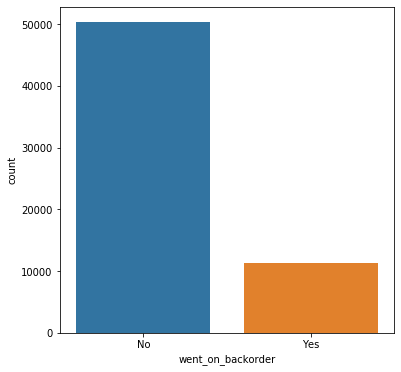

Count of different categories under Target columns
No     50296
Yes    11293
Name: went_on_backorder, dtype: int64

Percentages of different categories under Target columns
No     81.663933
Yes    18.336067
Name: went_on_backorder, dtype: float64


In [14]:
# Plot Distribution
plt.figure(figsize = (6, 6))
sns.countplot(x='went_on_backorder',data=data)
plt.show()

# What are the counts?
print("Count of different categories under Target columns")
print(f'{data.went_on_backorder.value_counts()}\n')

# What is the percentage?
print("Percentages of different categories under Target columns")
print((data.went_on_backorder.value_counts()/(data.shape[0])) * 100)

#### Seperating categorical and numeric attributes

In [15]:
cat_attr = list(data.select_dtypes(include=['category']).columns)
cat_attr.pop()

'went_on_backorder'

In [16]:
cat_attr

['potential_issue',
 'deck_risk',
 'oe_constraint',
 'ppap_risk',
 'stop_auto_buy',
 'rev_stop']

In [17]:
num_attr = list(data.columns.difference(cat_attr))
num_attr.pop()

'went_on_backorder'

In [18]:
num_attr

['forecast_3_month',
 'forecast_6_month',
 'forecast_9_month',
 'in_transit_qty',
 'lead_time',
 'local_bo_qty',
 'min_bank',
 'national_inv',
 'perf_12_month_avg',
 'perf_6_month_avg',
 'pieces_past_due',
 'sales_1_month',
 'sales_3_month',
 'sales_6_month',
 'sales_9_month']

### Performing train test split on the data

In [82]:
X, y = data.loc[:,data.columns!='went_on_backorder'], data.loc[:,'went_on_backorder']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

#### _Missing Values_

In [83]:
X_train.isnull().sum()

national_inv            0
lead_time            2391
in_transit_qty          0
forecast_3_month        0
forecast_6_month        0
forecast_9_month        0
sales_1_month           0
sales_3_month           0
sales_6_month           0
sales_9_month           0
min_bank                0
potential_issue         0
pieces_past_due         0
perf_6_month_avg        0
perf_12_month_avg       0
local_bo_qty            0
deck_risk               0
oe_constraint           0
ppap_risk               0
stop_auto_buy           0
rev_stop                0
dtype: int64

In [84]:
X_test.isnull().sum()

national_inv            0
lead_time            1012
in_transit_qty          0
forecast_3_month        0
forecast_6_month        0
forecast_9_month        0
sales_1_month           0
sales_3_month           0
sales_6_month           0
sales_9_month           0
min_bank                0
potential_issue         0
pieces_past_due         0
perf_6_month_avg        0
perf_12_month_avg       0
local_bo_qty            0
deck_risk               0
oe_constraint           0
ppap_risk               0
stop_auto_buy           0
rev_stop                0
dtype: int64

#### Handling Numerical Attributes - Preprocessing
##### Imputation (Filling missing values)

In [85]:
from sklearn.impute import SimpleImputer

num_imputer = SimpleImputer(strategy='mean')
num_imputer = num_imputer.fit(X_train[num_attr])

X_train_num = num_imputer.transform(X_train[num_attr])
X_train_num = pd.DataFrame(X_train_num, columns=num_attr)

X_test_num = num_imputer.transform(X_test[num_attr])
X_test_num = pd.DataFrame(X_test_num, columns=num_attr)

In [86]:
X_train_num.isnull().sum()

forecast_3_month     0
forecast_6_month     0
forecast_9_month     0
in_transit_qty       0
lead_time            0
local_bo_qty         0
min_bank             0
national_inv         0
perf_12_month_avg    0
perf_6_month_avg     0
pieces_past_due      0
sales_1_month        0
sales_3_month        0
sales_6_month        0
sales_9_month        0
dtype: int64

In [87]:
X_test_num.isnull().sum()

forecast_3_month     0
forecast_6_month     0
forecast_9_month     0
in_transit_qty       0
lead_time            0
local_bo_qty         0
min_bank             0
national_inv         0
perf_12_month_avg    0
perf_6_month_avg     0
pieces_past_due      0
sales_1_month        0
sales_3_month        0
sales_6_month        0
sales_9_month        0
dtype: int64

#### Handling Categorical Attributes - Preprocessing
##### Imputation (Filling missing values)

In [88]:
cat_imputer = SimpleImputer(strategy='most_frequent')
cat_imputer = cat_imputer.fit(X_train[cat_attr])


X_train_cat = cat_imputer.transform(X_train[cat_attr])
X_train_cat = pd.DataFrame(X_train_cat, columns= cat_attr)

X_test_cat = cat_imputer.transform(X_test[cat_attr])
X_test_cat = pd.DataFrame(X_test_cat, columns= cat_attr)

In [89]:
X_test_cat.isnull().sum()

potential_issue    0
deck_risk          0
oe_constraint      0
ppap_risk          0
stop_auto_buy      0
rev_stop           0
dtype: int64

In [90]:
X_test_cat.isnull().sum()

potential_issue    0
deck_risk          0
oe_constraint      0
ppap_risk          0
stop_auto_buy      0
rev_stop           0
dtype: int64

##### Encoding Categorical Attributes to Numeric - OneHotEncoding

In [92]:
onehotencoder = OneHotEncoder(handle_unknown='ignore')

onehotencoder = onehotencoder.fit(X_train_cat)

ohe_cat_col_names = onehotencoder.get_feature_names(cat_attr)
ohe_cat_col_names

array(['potential_issue_No', 'potential_issue_Yes', 'deck_risk_No',
       'deck_risk_Yes', 'oe_constraint_No', 'oe_constraint_Yes',
       'ppap_risk_No', 'ppap_risk_Yes', 'stop_auto_buy_No',
       'stop_auto_buy_Yes', 'rev_stop_No', 'rev_stop_Yes'], dtype=object)

In [93]:
X_train_cat_onehotencoded = onehotencoder.transform(X_train_cat).toarray()
X_train_cat_onehotencoded = pd.DataFrame(X_train_cat_onehotencoded, columns=ohe_cat_col_names)
X_train_cat_onehotencoded.head()

,potential_issue_No,potential_issue_Yes,deck_risk_No,deck_risk_Yes,oe_constraint_No,oe_constraint_Yes,ppap_risk_No,ppap_risk_Yes,stop_auto_buy_No,stop_auto_buy_Yes,rev_stop_No,rev_stop_Yes
0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


In [94]:
X_test_cat_onehotencoded = onehotencoder.transform(X_test_cat).toarray()
X_test_cat_onehotencoded = pd.DataFrame(X_test_cat_onehotencoded, columns=ohe_cat_col_names)
X_test_cat_onehotencoded.head()

,potential_issue_No,potential_issue_Yes,deck_risk_No,deck_risk_Yes,oe_constraint_No,oe_constraint_Yes,ppap_risk_No,ppap_risk_Yes,stop_auto_buy_No,stop_auto_buy_Yes,rev_stop_No,rev_stop_Yes
0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
4,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


#### Merging Numerical and Categorical Attributes

In [95]:
X_train = pd.concat([X_train_num, X_train_cat_onehotencoded], axis=1)
X_train.head()

,forecast_3_month,forecast_6_month,forecast_9_month,in_transit_qty,lead_time,local_bo_qty,min_bank,national_inv,perf_12_month_avg,perf_6_month_avg,...,deck_risk_No,deck_risk_Yes,oe_constraint_No,oe_constraint_Yes,ppap_risk_No,ppap_risk_Yes,stop_auto_buy_No,stop_auto_buy_Yes,rev_stop_No,rev_stop_Yes
0,100.0,100.0,100.0,0.0,2.0,0.0,4.0,30.0,0.91,0.95,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,0.0,0.0,0.0,0.0,4.0,0.0,0.0,8.0,0.78,0.73,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,0.0,6.0,12.0,0.0,8.0,0.0,1.0,5.0,0.99,0.98,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,0.0,0.0,0.0,0.0,4.0,0.0,0.0,5.0,0.78,0.73,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,14.0,26.0,44.0,2.0,8.0,0.0,4.0,1.0,0.74,0.75,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


In [96]:
X_train.shape

(43112, 27)

In [97]:
X_test = pd.concat([X_test_num, X_test_cat_onehotencoded], axis=1)
X_test.head()

,forecast_3_month,forecast_6_month,forecast_9_month,in_transit_qty,lead_time,local_bo_qty,min_bank,national_inv,perf_12_month_avg,perf_6_month_avg,...,deck_risk_No,deck_risk_Yes,oe_constraint_No,oe_constraint_Yes,ppap_risk_No,ppap_risk_Yes,stop_auto_buy_No,stop_auto_buy_Yes,rev_stop_No,rev_stop_Yes
0,0.0,0.0,0.0,0.0,8.0,0.0,1.0,2.0,0.98,0.99,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,0.0,0.0,0.0,0.0,8.0,0.0,0.0,8.0,0.88,0.95,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,0.0,0.0,0.0,0.0,2.0,0.0,0.0,11.0,0.99,1.00,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,0.0,170.0,340.0,1.0,8.0,0.0,60.0,214.0,0.90,0.90,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
4,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.92,0.92,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


In [98]:
print(X_train.shape)
print(X_test.shape)
print(len(y_train))
print(len(y_test))

(43112, 27)
(18477, 27)
43112
18477


In [102]:
y_train.unique()

[No, Yes]
Categories (2, object): [No, Yes]

In [120]:
# Define custom function to print accuracy, precision and recall

def convert_for_sklearn(label_list):
    return [1 if i == 'Yes' else 0 for i in label_list]


def accuracy_precision_recall_metrics(y_true, y_pred, data_mode):
    
    y_test_scoring = convert_for_sklearn(y_true)
    test_pred_scoring = convert_for_sklearn(y_pred)
    
#     y_test_scoring = y_true
#     test_pred_scoring = y_pred
    
    acc = accuracy_score(y_true= y_test_scoring, y_pred = test_pred_scoring)
    prec = precision_score(y_true= y_test_scoring, y_pred = test_pred_scoring)
    rec = recall_score(y_true= y_test_scoring, y_pred = test_pred_scoring)
    
    print(f"{data_mode} Precision: ",prec)
    print(f"{data_mode} Recall: ",rec)
    print(f"{data_mode} Accuracy: ",acc)

### _Build Random Forest Model_ (Using Stratified KFold)

__Stratified K-Folds cross-validator__

This cross-validation object is a **variation** of KFold that returns stratified folds. The folds are made by **preserving the percentage of samples for each class**.

In [105]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier()

In [108]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=143)

param_grid = {"n_estimators" : [150, 250, 300],
              "max_depth" : [5,8,10],
              "max_features" : [3, 5, 7],
              "min_samples_leaf" : [4, 6, 8, 10]}

rf_grid = GridSearchCV(clf_rf, param_grid= param_grid, cv=kfold)

In [109]:
rf_grid

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=143, shuffle=True),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
          

In [110]:
%%time
rf_grid.fit(X_train,y_train)

CPU times: user 49min 6s, sys: 1.6 s, total: 49min 8s
Wall time: 49min 7s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=143, shuffle=True),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
          

In [111]:
rf_grid.best_params_

{'max_depth': 10,
 'max_features': 7,
 'min_samples_leaf': 4,
 'n_estimators': 250}

### Extracting the important features

In [112]:
rf_grid.best_estimator_.feature_importances_

array([1.59621452e-01, 7.92351257e-02, 7.08929697e-02, 5.23153789e-02,
       1.57788974e-02, 2.52808095e-02, 2.14767792e-02, 3.42035540e-01,
       2.30931102e-02, 2.17822498e-02, 7.93613428e-03, 4.28589261e-02,
       3.97940382e-02, 4.02287490e-02, 4.55310197e-02, 2.88239341e-05,
       3.00957364e-05, 3.11344396e-03, 2.91475811e-03, 0.00000000e+00,
       0.00000000e+00, 1.73592629e-03, 1.80839789e-03, 1.24928539e-03,
       1.25274669e-03, 4.92070018e-07, 4.85033039e-06])

In [113]:
features = X_train.columns
importances = rf_grid.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1] # np.argsort returns the indices that would sort an array.
pd.DataFrame([X_train.columns[indices],np.sort(importances)[::-1]])

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,national_inv,forecast_3_month,forecast_6_month,forecast_9_month,in_transit_qty,sales_9_month,sales_1_month,sales_6_month,sales_3_month,local_bo_qty,...,ppap_risk_Yes,ppap_risk_No,stop_auto_buy_Yes,stop_auto_buy_No,potential_issue_Yes,potential_issue_No,rev_stop_Yes,rev_stop_No,oe_constraint_Yes,oe_constraint_No
1,0.342036,0.159621,0.0792351,0.070893,0.0523154,0.045531,0.0428589,0.0402287,0.039794,0.0252808,...,0.0018084,0.00173593,0.00125275,0.00124929,3.00957e-05,2.88239e-05,4.85033e-06,4.9207e-07,0,0


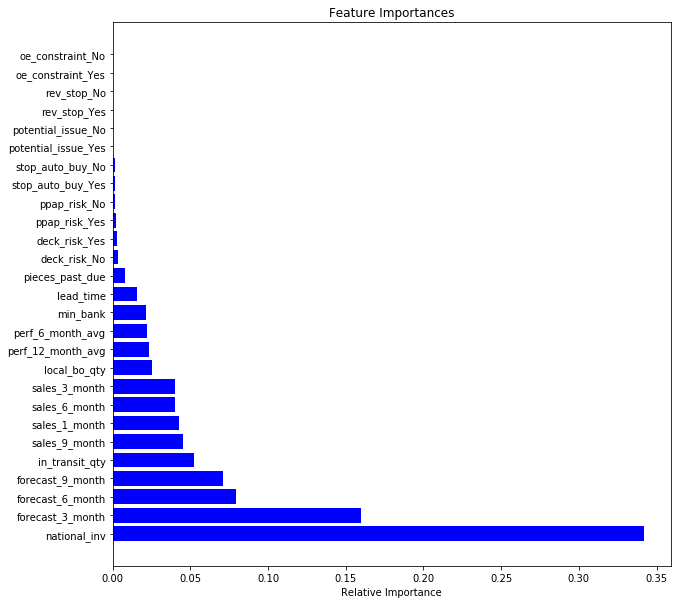

In [114]:
plt.figure(figsize = (10, 10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='blue')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [115]:
train_pred = rf_grid.predict(X_train)
test_pred = rf_grid.predict(X_test)

In [121]:
# Using the function to calculate accuracy, precision and recall.
accuracy_precision_recall_metrics(y_true = y_train, y_pred = train_pred, data_mode='Train')

Train Precision:  0.8366070129492216
Train Recall:  0.7283090563647878
Train Accuracy:  0.9241974392280572


In [122]:
# Using the function to calculate accuracy, precision and recall.
accuracy_precision_recall_metrics(y_true = y_test, y_pred = test_pred, data_mode='Test')

Test Precision:  0.8054607508532423
Test Recall:  0.694526191877575
Test Accuracy:  0.9129728852086377


### Selecting Most Important Features

In [123]:
select = indices[0:10]

In [126]:
clf_rf = RandomForestClassifier(max_depth= 10,max_features= 7,min_samples_leaf= 4,n_estimators= 250)

clf_rf.fit(X_train.iloc[:,select], y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features=7, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [127]:
train_pred = clf_rf.predict(X_train.iloc[:,select])
test_pred = clf_rf.predict(X_test.iloc[:,select])

In [128]:
# Using the function to calculate accuracy, precision and recall.
accuracy_precision_recall_metrics(y_true = y_train, y_pred = train_pred, data_mode="Train")

Train Precision:  0.8277601614298069
Train Recall:  0.7274224192526916
Train Accuracy:  0.9223650027834478


In [129]:
# Using the function to calculate accuracy, precision and recall.
accuracy_precision_recall_metrics(y_true = y_test, y_pred = test_pred, data_mode="Test")

Test Precision:  0.7940288493794029
Test Recall:  0.6965862271924662
Test Accuracy:  0.9109703956269958


## _Handling Imbalanced Data_

### _1. Class Weights of loss function_

In [134]:
%%time

from sklearn.tree import DecisionTreeClassifier

clf_dt = DecisionTreeClassifier()

dt_param_grid = {'criterion': ['entropy', 'gini'], 'max_depth': [6,8,10,12], 
                 "min_samples_split": [2, 10, 20],"min_samples_leaf": [1, 5, 10],
                 "class_weight":['balanced']}

dt_grid_bal = GridSearchCV(clf_dt, param_grid=dt_param_grid, cv=5)
dt_grid_bal.fit(X_train,y_train)

CPU times: user 1min 27s, sys: 24 ms, total: 1min 27s
Wall time: 1min 27s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'class_weight': ['balanced'],
                         'criterion': ['entropy', 'gini'],
                      

In [135]:
dt_grid_bal.best_estimator_

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=12,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [136]:
train_pred = dt_grid_bal.predict(X_train)
test_pred = dt_grid_bal.predict(X_test)

In [137]:
# Using the function to calculate accuracy, precision and recall.
accuracy_precision_recall_metrics(y_true = y_train, y_pred = train_pred, data_mode='Train')

Train Precision:  0.7087732411473419
Train Recall:  0.9608613046231792
Train Accuracy:  0.9205325663388384


In [138]:
# Using the function to calculate accuracy, precision and recall.
accuracy_precision_recall_metrics(y_true = y_test, y_pred = test_pred, data_mode='Test')

Test Precision:  0.6284862678305301
Test Recall:  0.8687463213655091
Test Accuracy:  0.8814201439627645


### _2. Oversample Using SMOTE_

<img src="SMOTE.jpg" width = '400'><br>

In [143]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)

os_data_X,os_data_y=smote.fit_sample(X_train, y_train)

os_data_X = pd.DataFrame(data=os_data_X)
os_data_y= pd.DataFrame(data=os_data_y,columns=['went_on_backorder'])

# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['went_on_backorder']=='No']))
print("Number of subscription",len(os_data_y[os_data_y['went_on_backorder']=='Yes']))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['went_on_backorder']=='No'])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['went_on_backorder']=='Yes'])/len(os_data_X))

length of oversampled data is  70434
Number of no subscription in oversampled data 35217
Number of subscription 35217
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [144]:
%%time
clf_dt = DecisionTreeClassifier()

dt_param_grid = {'criterion': ['entropy', 'gini'], 'max_depth': [6,8,10,12], 
                 "min_samples_split": [2, 10, 20],"min_samples_leaf": [1, 5, 10]}

dt_grid_bal = GridSearchCV(clf_dt, param_grid=dt_param_grid, cv=5)

dt_grid_bal.fit(os_data_X,os_data_y)

CPU times: user 3min 39s, sys: 44 ms, total: 3min 39s
Wall time: 3min 39s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [6, 8, 10, 12],
                       

In [145]:
train_pred = dt_grid_bal.predict(os_data_X).reshape(1,-1)[0]
test_pred = dt_grid_bal.predict(X_test).reshape(1,-1)[0]

print(dt_grid_bal.score(os_data_X, os_data_y))
print(dt_grid_bal.score(X_test, y_test))

0.9408666269131385
0.8927856253720842


In [146]:
confusion_matrix_train = confusion_matrix(y_true=os_data_y, y_pred = train_pred)
confusion_matrix_train

array([[32882,  2335],
       [ 1830, 33387]])

In [147]:
Accuracy_train=(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(np.sum(confusion_matrix_train))

Precision_Train= confusion_matrix_train[1,1]/(confusion_matrix_train[1,1]+confusion_matrix_train[0,1])
Recall_Train= confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train Precision: ",Precision_Train)
print("Train Recall: ",Recall_Train)
print("Train Accuracy: ",Accuracy_train)

Train Precision:  0.9346341190302895
Train Recall:  0.9480364596643667
Train Accuracy:  0.9408666269131385


In [148]:
accuracy_precision_recall_metrics(y_true = y_test, y_pred = test_pred, data_mode='Test')

Test Precision:  0.669052732044858
Test Recall:  0.8251912889935256
Test Accuracy:  0.8927856253720842


### Boosting

#### AdaBoost

<img src="bigd.png">

#### Create Adaboost Classifier

The most important parameters are base_estimator, n_estimators, and learning_rate.
-  **base_estimator** is the learning algorithm to use to train the weak models. This will almost always not needed to be changed because by far the most common learner to use with AdaBoost is a decision tree – this parameter’s default argument.
-  **n_estimators** is the number of models to iteratively train.
-  **learning_rate** is the contribution of each model to the weights and defaults to 1. Reducing the learning rate will mean the weights will be increased or decreased to a small degree, forcing the model train slower (but sometimes resulting in better performance scores).
-  **loss** is exclusive to AdaBoostRegressor and sets the loss function to use when updating weights. This defaults to a linear loss function however can be changed to square or exponential.


In [150]:
param_grid = {'n_estimators' : [100, 150, 200],
              'learning_rate' : [0.1, 0.5, 0.9]}

In [151]:
from sklearn.ensemble import AdaBoostClassifier

Adaboost_model_clf = GridSearchCV(AdaBoostClassifier(
            DecisionTreeClassifier(max_depth=2)), param_grid, n_jobs=-1)

%time Adaboost_model_clf.fit(X_train, y_train)

/home/chaitanyakanthvadlapudi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


CPU times: user 1min 25s, sys: 1.33 s, total: 1min 27s
Wall time: 2min 2s


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=DecisionTreeClassifier(class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=2,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
                                                                              

In [152]:
best_ada_model = Adaboost_model_clf.best_estimator_
best_ada_model

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                             

In [153]:
### Extracting the important features

Adaboost_model_clf.best_estimator_.feature_importances_

array([0.09745108, 0.03894991, 0.04441441, 0.05757646, 0.04103984,
       0.02908778, 0.05250251, 0.17593112, 0.06890249, 0.07539927,
       0.01421154, 0.07432735, 0.05578242, 0.04825921, 0.10601142,
       0.        , 0.        , 0.00216638, 0.00291128, 0.        ,
       0.        , 0.00208148, 0.00275192, 0.00702659, 0.00069185,
       0.        , 0.00252369])

In [154]:
features = X_train.columns
importances = Adaboost_model_clf.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1] # np.argsort returns the indices that would sort an array.
pd.DataFrame([X_train.columns[indices],np.sort(importances)[::-1]])

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,national_inv,sales_9_month,forecast_3_month,perf_6_month_avg,sales_1_month,perf_12_month_avg,in_transit_qty,sales_3_month,min_bank,sales_6_month,...,ppap_risk_Yes,rev_stop_Yes,deck_risk_No,ppap_risk_No,stop_auto_buy_Yes,potential_issue_No,oe_constraint_Yes,oe_constraint_No,rev_stop_No,potential_issue_Yes
1,0.175931,0.106011,0.0974511,0.0753993,0.0743274,0.0689025,0.0575765,0.0557824,0.0525025,0.0482592,...,0.00275192,0.00252369,0.00216638,0.00208148,0.000691853,0,0,0,0,0


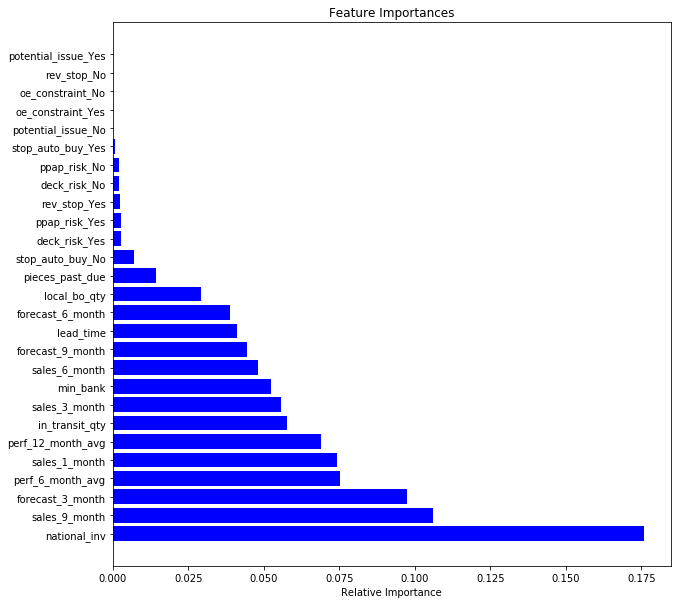

In [155]:
plt.figure(figsize = (10, 10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='blue')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [156]:
train_pred = Adaboost_model_clf.predict(X_train)
test_pred = Adaboost_model_clf.predict(X_test)

In [157]:
# Using the function to calculate accuracy, precision and recall.
accuracy_precision_recall_metrics(y_true = y_train, y_pred = train_pred,data_mode='Train')

Train Precision:  0.7906362878577382
Train Recall:  0.7208359721342622
Train Accuracy:  0.9139218778994248


In [158]:
# Using the function to calcula`te accuracy, precision and recall.
accuracy_precision_recall_metrics(y_true = y_test, y_pred = test_pred, data_mode='Test')

Test Precision:  0.7850805126519882
Test Recall:  0.7030606238964097
Test Accuracy:  0.9099962115061969


### Gradient Boosting 

In [159]:
from sklearn.ensemble import GradientBoostingClassifier

clf_gbm = GradientBoostingClassifier()

In [160]:
%%time
gbm_param_grid = {'max_depth': [8,10,12,14], 'subsample': [0.8, 0.6,], 'max_features':[0.2, 0.3], 
              'n_estimators': [10, 20, 30]}

gbm_grid = GridSearchCV(clf_gbm, param_grid=gbm_param_grid, cv=3)

gbm_grid.fit(X_train,y_train)

CPU times: user 13min 22s, sys: 2.43 s, total: 13min 25s
Wall time: 11min 43s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  presort=

In [161]:
gbm_grid.best_params_

{'max_depth': 14, 'max_features': 0.3, 'n_estimators': 30, 'subsample': 0.8}

### Extracting the important features

In [162]:
gbm_grid.best_estimator_.feature_importances_

array([1.16065059e-01, 6.17660382e-02, 8.62019644e-02, 3.90782397e-02,
       3.10463115e-02, 9.65229562e-03, 3.15789879e-02, 2.70323372e-01,
       6.13854856e-02, 5.70555912e-02, 6.75108810e-03, 5.06187723e-02,
       4.34804482e-02, 5.24562811e-02, 5.47313048e-02, 3.10041732e-04,
       2.62948404e-04, 6.30548583e-03, 5.73030982e-03, 6.36077438e-05,
       2.21190101e-05, 4.76045821e-03, 5.36812045e-03, 2.78979421e-03,
       2.00124164e-03, 1.14035121e-04, 8.05983178e-05])

In [163]:
features = X_train.columns
importances = gbm_grid.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1] # np.argsort returns the indices that would sort an array.
pd.DataFrame([X_train.columns[indices],np.sort(importances)[::-1]])

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,national_inv,forecast_3_month,forecast_9_month,forecast_6_month,perf_12_month_avg,perf_6_month_avg,sales_9_month,sales_6_month,sales_1_month,sales_3_month,...,ppap_risk_Yes,ppap_risk_No,stop_auto_buy_No,stop_auto_buy_Yes,potential_issue_No,potential_issue_Yes,rev_stop_No,rev_stop_Yes,oe_constraint_No,oe_constraint_Yes
1,0.270323,0.116065,0.086202,0.061766,0.0613855,0.0570556,0.0547313,0.0524563,0.0506188,0.0434804,...,0.00536812,0.00476046,0.00278979,0.00200124,0.000310042,0.000262948,0.000114035,8.05983e-05,6.36077e-05,2.2119e-05


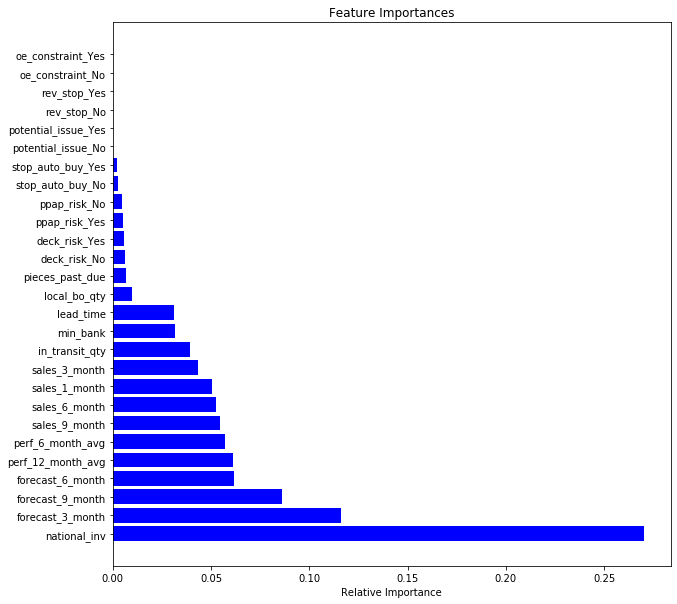

In [164]:
plt.figure(figsize = (10, 10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='blue')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [165]:
train_pred = gbm_grid.predict(X_train)
test_pred = gbm_grid.predict(X_test)

In [166]:
# Using the function to calculate accuracy, precision and recall.
accuracy_precision_recall_metrics(y_true = y_train, y_pred = train_pred,data_mode='Train')

Train Precision:  0.9849643221202854
Train Recall:  0.9791006966434452
Train Accuracy:  0.9934357023566525


In [167]:
# Using the function to calcula`te accuracy, precision and recall.
accuracy_precision_recall_metrics(y_true = y_test, y_pred = test_pred, data_mode='Test')

Test Precision:  0.8334350213544844
Test Recall:  0.8040023543260741
Test Accuracy:  0.9344049358662121


### XGBOOST Classifier
XGBoost (eXtreme Gradient Boosting) is an advanced implementation of gradient boosting algorithm.

<img src="xgboost.png" >

#### The XGBoost Advantages
-  Regularization:
    -  Standard GBM implementation has no regularization like XGBoost, therefore it also helps to reduce overfitting.
    -  In fact, XGBoost is also known as ‘regularized boosting‘ technique.
-  Parallel Processing:
    -  XGBoost implements parallel processing and is blazingly faster as compared to GBM.
    -  Boosting is sequential process that each tree can be built only after the previous one, and it  can be parallelized with making a tree using all cores. Refer. http://zhanpengfang.github.io/418home.html
    
    -  XGBoost also supports implementation on Hadoop.
-  High Flexibility
    -  XGBoost allow users to define custom optimization objectives and evaluation criteria.
    -  This adds a whole new dimension to the model and there is no limit to what we can do.
-  Handling Missing Values
    -  XGBoost has an in-built routine to handle missing values.
    -  User is required to supply a different value than other observations and pass that as a parameter. XGBoost tries different things as it encounters a missing value on each node and learns which path to take for missing values in future.
-  Tree Pruning:
    -  A GBM would stop splitting a node when it encounters a negative loss in the split. Thus it is more of a greedy algorithm.
    -  XGBoost on the other hand make splits upto the max_depth specified and then start pruning the tree backwards and remove splits beyond which there is no positive gain.
    -  Another advantage is that sometimes a split of negative loss say -2 may be followed by a split of positive loss +10. GBM would stop as it encounters -2. But XGBoost will go deeper and it will see a combined effect of +8 of the split and keep both.
-  Built-in Cross-Validation
    -  XGBoost allows user to run a cross-validation at each iteration of the boosting process and thus it is easy to get the exact optimum number of boosting iterations in a single run.
    -  This is unlike GBM where we have to run a grid-search and only a limited values can be tested.
-  Continue on Existing Model
    -  User can start training an XGBoost model from its last iteration of previous run. This can be of significant advantage in certain specific applications.
    -  GBM implementation of sklearn also has this feature so they are even on this point.

#### Installing XGBoost

* Execute below command in terminal


* pip install xgboost
   *   OR
* sudo conda install -c conda-forge xgboost (Run in conda prompt)

#### Create XGBoost Classifier

There are different hyperparameters that we can tune and the parametres are different from baselearner to baselearner. 
<br>In tree based learners, which are the most common ones in xgboost applications, the following are the most commonly tuned hyperparameters:

-  **learning rate/eta:** governs how quickly the model fits the residual error using additional base learners. If it is a smaller learning rate, it will need more boosting rounds, hence more time, to achieve the same reduction in residual error as one with larger learning rate. Typically, it lies between 0.01 – 0.3
-  **max_depth:** max depth per tree. This controls how deep our tree can grow. The Larger the depth, more complex the model will be and higher chances of overfitting. Larger data sets require deep trees to learn the rules from data. Default = 6.
-  **subsample:** % samples used per tree. This is the fraction of the total training set that can be used in any boosting round. Low value may lead to underfitting issues. A very high value can cause over-fitting problems.
-  **colsample_bytree:** % features used per tree. This is the fraction of the number of columns that we can use in any boosting round. A smaller value is an additional regularization and a larger value may be cause overfitting issues.
-  **n_estimators:** number of estimators (base learners). This is the number of boosting rounds.
<br><br>The three hyperparameters below are regularization hyperparameters.
-  **gamma:** min loss reduction to create new tree split. default = 0 means no regularization.
-  **lambda:** L2 reg on leaf weights. Equivalent to Ridge regression.
-  **alpha:** L1 reg on leaf weights. Equivalent to Lasso regression.


Refer: https://xgboost.readthedocs.io/en/latest/python/python_api.html

### Use a grid over parameters of interest

In [19]:
from xgboost import XGBClassifier

XGB = XGBClassifier(n_jobs=-1,)

In [169]:
param_grid = {
     'colsample_bytree': np.linspace(0.5, 0.9, 2),
     'n_estimators':[100],
     'max_depth': [10, 15]
}

 
CV_XGB = GridSearchCV(estimator=XGB, param_grid=param_grid, cv= 10)

%time CV_XGB.fit(X = X_train, y=y_train)

CPU times: user 10min 51s, sys: 2.34 s, total: 10min 53s
Wall time: 2min 50s


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bytree=1,
                                     gamma=0, learning_rate=0.1,
                                     max_delta_step=0, max_depth=3,
                                     min_child_weight=1, missing=None,
                                     n_estimators=100, n_jobs=-1, nthread=None,
                                     objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=True,
                                     subsample=1),
             iid='warn', n_jobs=None,
             param_grid={'colsample_bytree': array([0.5, 0.9]),
                         'max_depth': [10, 15], 'n_estimators': [100]},
             pre_dispatch='2*n_jobs', refit=True, return_train

In [170]:
best_xgb_model = CV_XGB.best_estimator_
best_xgb_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.5, gamma=0, learning_rate=0.1,
              max_delta_step=0, max_depth=15, min_child_weight=1, missing=None,
              n_estimators=100, n_jobs=-1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
              subsample=1)

In [171]:
### Extracting the important features

CV_XGB.best_estimator_.feature_importances_

array([0.07742557, 0.04616192, 0.04204708, 0.08197753, 0.0331687 ,
       0.07175995, 0.02495592, 0.18012872, 0.0246708 , 0.02264963,
       0.03487536, 0.04720345, 0.02757119, 0.03982152, 0.02940667,
       0.0139529 , 0.02985399, 0.02320259, 0.03670232, 0.        ,
       0.        , 0.02250328, 0.0222048 , 0.03692283, 0.0308333 ,
       0.        , 0.        ], dtype=float32)

In [172]:
features = X_train.columns
importances = CV_XGB.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1] # np.argsort returns the indices that would sort an array.
pd.DataFrame([X_train.columns[indices],np.sort(importances)[::-1]])

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,national_inv,in_transit_qty,forecast_3_month,local_bo_qty,sales_1_month,forecast_6_month,forecast_9_month,sales_6_month,stop_auto_buy_No,deck_risk_Yes,...,perf_12_month_avg,deck_risk_No,perf_6_month_avg,ppap_risk_No,ppap_risk_Yes,potential_issue_No,oe_constraint_Yes,oe_constraint_No,rev_stop_No,rev_stop_Yes
1,0.180129,0.0819775,0.0774256,0.07176,0.0472034,0.0461619,0.0420471,0.0398215,0.0369228,0.0367023,...,0.0246708,0.0232026,0.0226496,0.0225033,0.0222048,0.0139529,0,0,0,0


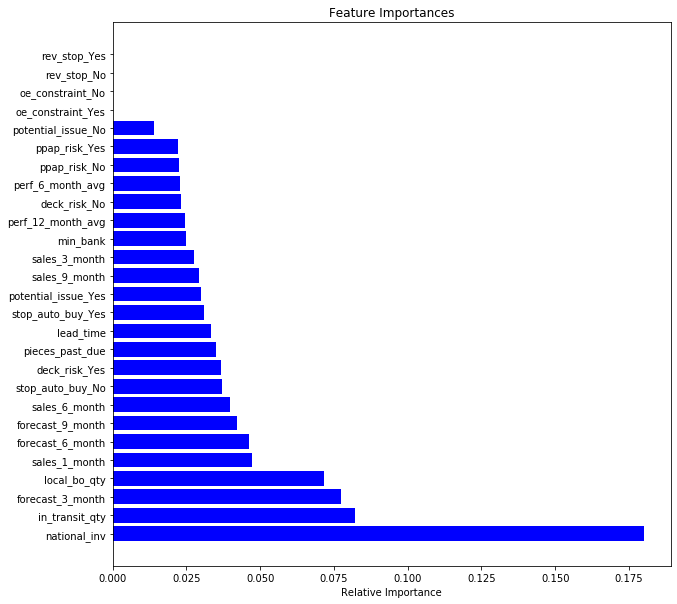

In [173]:
plt.figure(figsize = (10, 10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='blue')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [174]:
train_pred = CV_XGB.predict(X_train)
test_pred = CV_XGB.predict(X_test)

In [175]:
# Using the function to calculate accuracy, precision and recall.
accuracy_precision_recall_metrics(y_true = y_train, y_pred = train_pred,data_mode='Train')

Train Precision:  0.9921249677252776
Train Recall:  0.9734008866371121
Train Accuracy:  0.9937140471330488


In [176]:
# Using the function to calcula`te accuracy, precision and recall.
accuracy_precision_recall_metrics(y_true = y_test, y_pred = test_pred, data_mode='Test')

Test Precision:  0.8370904718966036
Test Recall:  0.8195997645673926
Test Accuracy:  0.9374898522487417


### Observation:

XGBoost performs really well when compared to all the base algorithms we ran. 